In [1]:
# Import necessary libraries
import cdflib
import xarray as xr

import numpy as np
import pandas as pd
from scipy.signal import find_peaks
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import ecef_geodetic


import sys
sys.path.append('../../SAMI3-GITM-python')
import SAMI3_ESMF_Regrid



In [2]:
fnames = ['GR_OPER_TEC1TMS_2F_20130316T000000_20130316T235959_0101.cdf', 
         'GR_OPER_TEC1TMS_2F_20130317T000000_20130317T235959_0101.cdf', 
         'GR_OPER_TEC1TMS_2F_20130318T000000_20130318T235959_0101.cdf', 
         # 'GR_OPER_TEC2TMS_2F_20130316T000000_20130316T235959_0101.cdf', 
         # 'GR_OPER_TEC2TMS_2F_20130317T000000_20130317T235959_0101.cdf', 
         # 'GR_OPER_TEC2TMS_2F_20130318T000000_20130318T235959_0101.cdf'
         ]

## Read in data

In [3]:
# Same as old Prasoon code - maybe could be changed? Works fine though
# Modification marked below:

grace = [] # list of Xarray DataSets from each day

for f in tqdm(fnames): # Probably don't need a progress bar here. only takes ~15 seconds
    path = 'ESA_GRACE_data/' + f
    data = xr.Dataset()
    d = cdflib.CDF(path)

    step = range(len(d['Timestamp']))
    
    for var_name in d.cdf_info().zVariables:
        
        var_data = d[var_name]

        if var_name == 'DCB' or var_name == 'DCB_Error' :
            data[var_name] = d[var_name]
        
        elif type(var_data[0]) == np.ndarray:
            var_name1 = var_name + '_X'
            var_name2 = var_name + '_Y'
            var_name3 = var_name + '_Z'
            data[var_name1] = ('step', [i for i,j,k in var_data], {'step': step})
            data[var_name2] = ('step', [j for i,j,k in var_data], {'step': step})
            data[var_name3] = ('step', [k for i,j,k in var_data], {'step': step})

        else:
            data[var_name] = ('step', var_data, {'step': step})


    d0 = pd.Timestamp(f.split('_')[-2])  # Aaron changed how date_0 was calculated.
    date = [d0 + pd.Timedelta(milliseconds = (i - data.Timestamp[0].values)) for i in data.Timestamp.values]
    data['date'] = ('step', [i for i in date], {'step': step})
    lt = ecef_geodetic.ut_to_lt(date, data['Longitude'].values)
    data['LT'] = ('step', lt, {'step':step})
    
    grace.append(data)

print('Columns in Satellite Data: \n', data.data_vars, 
      'Start & end dates:', data.date.min().values, data.date.max().values)

  0%|          | 0/3 [00:00<?, ?it/s]

Columns in Satellite Data: 
 Data variables:
    Timestamp          (step) float64 438kB 6.353e+13 6.353e+13 ... 6.353e+13
    Latitude           (step) float64 438kB -59.12 -59.12 -59.77 ... 24.74 24.74
    Longitude          (step) float64 438kB -175.2 -175.2 -175.2 ... 2.673 2.673
    Radius             (step) float64 438kB 6.825e+06 6.825e+06 ... 6.822e+06
    GPS_Position_X     (step) float64 438kB 1.975e+06 -3.314e+06 ... 2.534e+07
    GPS_Position_Y     (step) float64 438kB -1.886e+07 -2.172e+07 ... -7.897e+06
    GPS_Position_Z     (step) float64 438kB -1.894e+07 -1.513e+07 ... 3.192e+06
    LEO_Position_X     (step) float64 438kB -3.49e+06 -3.49e+06 ... 6.189e+06
    LEO_Position_Y     (step) float64 438kB -2.959e+05 -2.959e+05 ... 2.89e+05
    LEO_Position_Z     (step) float64 438kB -5.858e+06 -5.858e+06 ... 2.855e+06
    PRN                (step) uint16 109kB 11 32 11 32 11 32 ... 21 25 29 30 31
    L1                 (step) float64 438kB 2.347e+07 2.351e+07 ... 2.074e+07
  

In [19]:
# Data is flat - convert it to a Pandas DataFrame. 
# They're easier to work with and writing csv files is built-in.

# Concat the list of xr Datasets, converting each to Pandas as we go
df = pd.concat([i.to_pandas() for i in grace]).sort_values('date')

# Only select columns I care about - drop the index too 
df = df[['Timestamp', 'GPS_Position_X', 
       'GPS_Position_Y', 'GPS_Position_Z', 'LEO_Position_X', 'LEO_Position_Y',
       'LEO_Position_Z', 'PRN', 'Latitude', 'Longitude',
       'Absolute_STEC', 'Elevation_Angle', 'date', 'LT']].reset_index(drop=True)

## Mask off data we don't want

This should be easy to change if other data is required

The variable `df` is kept so the code after selecting data is generalizable. 

There is some debug info printed & plotted. None of that is necessary... I'm leaving it in for proofthat the code is working as expected. The cells can be deleted. I would have but wanted to show Prasoon what's happening

In [20]:
# Only keep data on the 17th

In [21]:
df = df.iloc[np.where((df.date > pd.Timestamp('20130317'))
                    & (df.date < pd.Timestamp('20130318')))].reset_index(drop=True)

In [22]:
# Just check to make sure things look right - can delete this cell. not needed
df.columns, df.PRN.unique(), df.date.min(), df.date.max()

(Index(['Timestamp', 'GPS_Position_X', 'GPS_Position_Y', 'GPS_Position_Z',
        'LEO_Position_X', 'LEO_Position_Y', 'LEO_Position_Z', 'PRN', 'Latitude',
        'Longitude', 'Absolute_STEC', 'Elevation_Angle', 'date', 'LT'],
       dtype='object'),
 array([11, 12, 14, 18, 25, 31, 21, 30,  6, 16, 29,  3,  5, 13,  7, 10, 26,
         2,  8,  4,  9, 28, 17, 20, 32, 22, 19, 15, 23], dtype=uint16),
 Timestamp('2013-03-17 00:00:09'),
 Timestamp('2013-03-17 23:59:59'))

### Select one orbit

Since this is just me debgging, I'm going to filter by day AND only take one of those orbits. 

In [23]:
# Find where absolute value of df.Latitude is highest
# Returns peaks & their values. don't care about values, store it as a `_` and forget about it.
peaks, _ = find_peaks(df.Latitude.abs())

In [24]:
# Select a random orbit. Needs to be a slice (with +2 at the end) since it indexes with [,)
#  The start is inclusive, end is exclusive. 
#  i.e. [1,2,3,4,5][1:2] = [1]    &    [1,2,3,4,5][1:3] = [1,2]
orbit_num = 3
peaks = peaks[orbit_num:orbit_num+2]
peaks

array([6871, 8788])

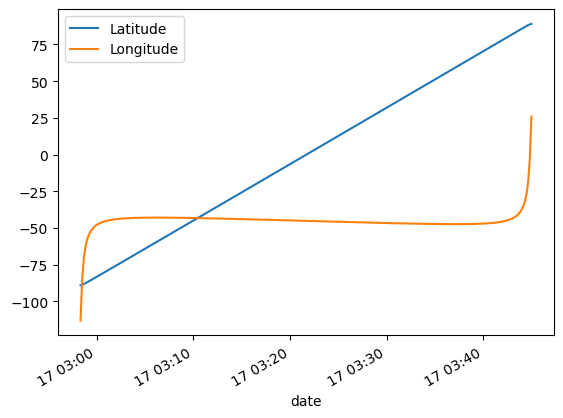

In [25]:
# Plot to make sure it looks ok...
ax = plt.subplot()
df.iloc[peaks[0]:peaks[1]].plot(x='date', y='Latitude', ax=ax)
df.iloc[peaks[0]:peaks[1]].plot(x='date', y='Longitude', ax=ax);

In [26]:
# Now set df to be that slice 
# Keep using the same variable so these cells can be deleted if an entire 
#  day of satellite data is desired
#  Should be easy to modify to and select different data...

df = df.iloc[peaks[0]:peaks[1]].reset_index(drop=True)
df.head(), df.tail()

(      Timestamp  GPS_Position_X  GPS_Position_Y  GPS_Position_Z  \
 0  6.353062e+13    1.557904e+07    2.632128e+06   -2.122026e+07   
 1  6.353062e+13   -1.337761e+07    1.177066e+07   -1.964828e+07   
 2  6.353062e+13   -1.478301e+07   -6.234907e+06   -2.147005e+07   
 3  6.353062e+13    1.054131e+07   -1.453524e+07   -1.972966e+07   
 4  6.353062e+13   -1.476830e+07   -6.257162e+06   -2.147346e+07   
 
    LEO_Position_X  LEO_Position_Y  LEO_Position_Z  PRN   Latitude   Longitude  \
 0   -47253.079917  -111047.071560   -6.828250e+06   31 -88.987458 -113.050867   
 1   -47253.079917  -111047.071560   -6.828250e+06   12 -88.987458 -113.050867   
 2   -47253.079917  -111047.071560   -6.828250e+06    4 -88.987458 -113.050867   
 3   -47253.079917  -111047.071560   -6.828250e+06   20 -88.987458 -113.050867   
 4    11679.362727  -159308.654014   -6.827549e+06    4 -88.659762  -85.806988   
 
    Absolute_STEC  Elevation_Angle                date         LT  
 0       7.504255        41.

## Make the "rays" along line of sight from cartesian positions of grace and gps

Use the start & end points and then a weighting factor to scale.

I will use log-spacing but the option for linear spacing is included.

Since this is a calculation that will be called a bunch, write it as a separate function for increased readability.


What I want to do is define a vector from start -> end. Then I will get the distance from start point (specified by the linear vs log spacing) and multiply this by the slope (so it is a vector in the direction & magnitude we want). Add that to the start location and the result is what we want.


In [27]:
def line_of_sight_calc(start, end, #start and end pts
                       num_points=50, # number of points 
                       base = 4, # Adjust base of log to get required point density
                       spacing='log'): # currently supports log & linear
    # Calculate direction vector
    direction = np.array(end) - np.array(start)
    
    if spacing == 'log':
        # see below for a discussion on why I did this
        deltas = np.geomspace(0.00001, 1, num=num_pts) ** (base/10)
    
    elif spacing == 'linear':
        deltas = np.linspace(0, 1, num=num_points)
        
    else:
        raise ValueError
    
    # Scale and translate values to fit the line segment
    points = [start + t * direction for t in deltas]

    return points

### np.logspace() is weird.

The arguments are start, stop, num_points, base, etc.

What's weird is that the returned points are actually in the range start^base to end^base

Found a workaround that is displayed below, but it is easier to just use np.geomspace()


You can play with both below & find the parameters you want to use.

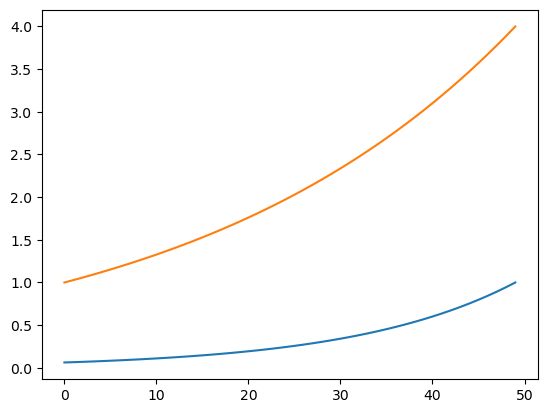

In [28]:
# Play with logspace here:
base = 2
num_pts = 50

raw_logspace = np.logspace(0, base, num=num_pts, base=base)
better_logspace = np.flip(raw_logspace ** -base)
plt.plot(better_logspace)

plt.plot(raw_logspace); # Comment out this line to only see the "good" logspace. 
# Try increasing the base and you'll see how weird it is.

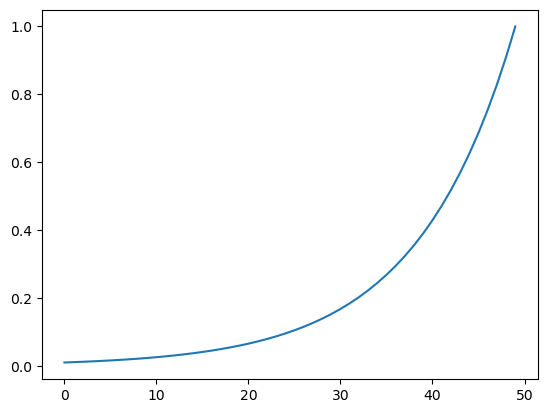

In [29]:
# Play with geomspace here:
base = 4
num_pts = 50
out_alts = np.geomspace(0.00001, 1, num=num_pts) ** (base/10)
plt.plot(out_alts);

I like the look of geomspace with base=4. That's what I'll use. (That doesn't mean it's right, so you might want to test a few...)

### Make the output (ar)rays

In [30]:
# Make a new dataframe so we aren't reusing the last one for everything.
# Data will all be added at the end but it is easier to keep them separate
df_raypaths = pd.DataFrame()

In [31]:
cartesian_points = [] # List so I can append to it.

In [48]:
# Iterate thru points in dataframe
# Could be vectorized if speed is ever an issue

for _, row in df.iterrows(): # Returns index, row... don't care about index
    
    grace_cart_loc = [row['LEO_Position_X'],
                      row['LEO_Position_Y'],
                      row['LEO_Position_Z']]

    gps_cart_loc = [row['GPS_Position_X'],
                    row['GPS_Position_Y'],
                    row['GPS_Position_Z']]
    
    # Compute ray - this is a (N_points, 3) shaped array
    a_ray = line_of_sight_calc(grace_cart_loc, gps_cart_loc, )
    
    # Convert back to lat/lon/alt - ecef conversions need x,y,z & can't be vectorized
    a_ray_sph = [] # Same shape as a_ray
    for pt in a_ray:
        a_ray_sph.append(ecef_geodetic.ecef_to_lla(*pt))
        
    
    cartesian_points.append(a_ray_sph)

cartesian_points = np.array(cartesian_points) # easier to slice from than list

In [49]:
print('shape of cartesian_points: ', cartesian_points.shape)

shape of cartesian_points:  (3835, 50, 3)


so be careful about adding a lot of points...

### Making output DataFrame. 



In [53]:
df_raypaths['lat'] = cartesian_points[:,:,0].flatten()
df_raypaths['lon'] = cartesian_points[:,:,1].flatten()
df_raypaths['alt'] = cartesian_points[:,:,2].flatten() / 1000

In [54]:
df_raypaths

,lat,lon,alt
0,-88.878036,-37.489775,616.763347
1,-88.790508,-33.039025,631.166671
2,-88.687609,-28.877512,647.028260
3,-88.568398,-25.033795,664.499552
4,-88.431946,-21.518385,683.748403
...,...,...,...
191745,45.863609,-95.256932,13227.844817
191746,44.575111,-95.295136,14687.014855
191747,43.351436,-95.329886,16300.590115
191748,42.193853,-95.361497,18083.437149


### Write dataframe to file

In [56]:
df_raypaths.to_csv('single_orbit_los.csv')

## Run ESMF code

Not necessary to call os.system() since you imported the SAMI3-ESMF function.

Can call the Python from here - I will do interpolation in this file and then analyze it elsewhere.

> This will need to be changed by whoever runs it!

In [ ]:
SAMI3_ESMF_Regrid.main(sami_data_path='../../../scratch/2013-03-17_SAMI', 
                       dtime_sim_start='20130316',
                       cols='edens',
                       out_dir='../../../2013-03-17_SAMI',
                       custom_input_file='single_orbit_los.csv',
                       ESMF_DIR='../../esmf-8.5.0/apps/appsO/Linux.intel.64.mvapich2.default/',
                       remake_files=True,
                         ) 